# Text generation with deep learning

In [2]:
import sys
import os
import os.path
import random
import collections
import shutil
import time
import glob
import csv

import numpy as np
import pandas as pd
from math import pi
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
%matplotlib inline

**Задача**

   Обучить character recurrent neural network (char RNN) на датасете статей arxiv, а также на своих данных и исследовать её свойства.

Определим структуру сети, в качестве основного блока используем **GRU**

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)
    
    def save_model(model, filename='rnn.ckpt'):
        checkpoint = {'input_size': model.input_size,
                      'hidden_size': model.hidden_size,
                      'output_size': model.output_size,
                      'n_layers': model.n_layers,
                      'state_dict': model.state_dict()}
        with open(filename, 'wb') as f:
            torch.save(checkpoint, f)

    def load_model(filename):

        with open(filename, 'rb') as f:
            checkpoint = torch.load(f)

        model = RNN(input_size = checkpoint['input_size'], output_size = checkpoint['output_size'], hidden_size=checkpoint['hidden_size'], n_layers=checkpoint['n_layers'])
        model.load_state_dict(checkpoint['state_dict'])

        return model

# Пример реализации класса для получения данных из датасета

In [ ]:
class TextDataset(Dataset):
    def __init__(self, text, chunk_len=10, chunks_number=100):
        self.chunks_number = chunks_number
        self.chunk_len = chunk_len
        self.text = text
        self.all_symbols = list({x for x in self.text})
    
    def __len__(self):
        return self.chunks_number
    
    def _get_tensor(self, text):
        return torch.LongTensor(list(map(self.all_symbols.index, text))).cuda()
    
    def _decode_vector(self, text):
        text = text.view(-1).cpu().numpy()
        if text.shape[0] == 1:
            text = list(text)
        return ''.join([self.all_symbols[x] for x in text])
    
    def _get_random_slice(self):
        start_index = random.randint(0, len(self.text) - self.chunk_len)
        end_index = start_index + self.chunk_len + 1
        return self.text[start_index:end_index]
    
    def __getitem__(self, idx):
        chunk = self._get_random_slice()
        return self._get_tensor(chunk[:-1]), self._get_tensor(chunk[1:])

# Здесь должен быть код для считывания данных и создания даталоадера

In [6]:
arxiv_csv = pd.read_csv('data/arxiv_papers.csv')
arxiv_csv.head()

,link,time,favorites,rts,authors,category,published,summary,title,tweeted
0,arxiv.org/abs/1611.10003,NaN,NaN,NaN,"[Tom A. F. Anderson, C. -H. Ruan]",q-bio.NC,2016-11-30 05:17:11,In summary of the research findings presented ...,Vocabulary and the Brain: Evidence from Neuroi...,0
1,arxiv.org/abs/1611.10007,NaN,NaN,NaN,"[M. Amin Rahimian, Amir G. Aghdam]",cs.SY,2016-11-30 05:37:11,"In this paper, structural controllability of a...",Structural Controllability of Multi-Agent Netw...,0
2,arxiv.org/abs/1611.10010,NaN,NaN,NaN,"[Debidatta Dwibedi, Tomasz Malisiewicz, Vijay ...",cs.CV,2016-11-30 06:00:47,We present a Deep Cuboid Detector which takes ...,Deep Cuboid Detection: Beyond 2D Bounding Boxes,0
3,arxiv.org/abs/1611.10012,2016-12-01 01:46:12,11.0,2.0,"[Jonathan Huang, Vivek Rathod, Chen Sun, Mengl...",cs.CV,2016-11-30 06:06:15,"In this paper, we study the trade-off between ...",Speed/accuracy trade-offs for modern convoluti...,1
4,arxiv.org/abs/1611.10014,NaN,NaN,NaN,"[Yoones Hashemi, Amir H. Banihashemi]",cs.IT,2016-11-30 06:12:45,"In this paper, we propose a characterization o...",Characterization and Efficient Exhaustive Sear...,0


In [ ]:
class ArxivDataset(Dataset):
    def __init__(self, dataframe):
        self.texts = arxiv_csv['summary'].tolist()
        self.target = arxiv_csv['title'].tolist()
        self.all_symbols = []
        for text in self.texts:
            self.all_symbols.extend({x for x in text})
        self.all_symbols = set(self.all_symbols)
    
    def __len__(self):
        return len(self.texts)
    
    def _get_tensor(self, text):
        return torch.LongTensor(list(map(self.all_symbols.index, text))).cuda()
    
    def _decode_vector(self, text):
        text = text.view(-1).cpu().numpy()
        if text.shape[0] == 1:
            text = list(text)
        return ''.join([self.all_symbols[x] for x in text])
    
    def __getitem__(self, idx):
        chunk = self._get_random_slice()
        return self._get_tensor(chunk[:-1]), self._get_tensor(chunk[1:])

Смотрим, сколько уникальных символов есть в датасете - это и будет размер выходного вектора у нейронной сети

In [ ]:
unique_symbols = len(arxiv_dataset.all_symbols)
n_layers = 2
hidden_size = 100

In [ ]:
unique_symbols

65

In [ ]:
net = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)

In [ ]:
device = torch.device("cuda")

In [ ]:
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().cuda()

# Здесь нужно реализовать функцию для генерации текста с помощью сети

In [ ]:
def generate(net, device, dataset, prime_str='А', predict_len=100, temperature=0.8):
    #Code to generate string based on input sequence (prime_str)

    return predicted_string

# Здесь должен быть цикл тренировки

In [ ]:
epochs = 100

In [ ]:
start = time.time()

for epoch in range(1, epochs+1):
    for inputs, targets in loader:
        #Your code for training here
print("Saving...")
RNN.save_model(net, "TrainedModel.ckpt")

In [ ]:
net(inputs[0], hidden)[0].shape

torch.Size([1, 65])

In [ ]:
targets[0]

tensor(46, device='cuda:0')

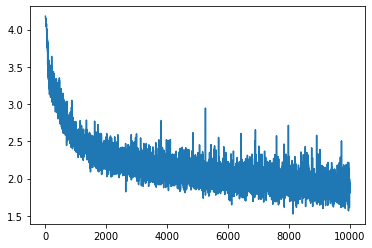

In [ ]:
plt.figure()
plt.plot(all_losses)

## Результаты тренировки

In [ ]:
print(generate(net, device, arxiv_dataset, 'In this research', 200 ), '\n')

# Здесь должны быть эксперименты с архитектурой и параметрами сети

# Здесь будет работа с вашими датасетами (которые вы захотите использовать)